In [1]:
import matplotlib
#matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
from collections import defaultdict, OrderedDict


import os
import sys
import re
import numpy as np
import pandas as pd
import scipy.optimize
rmg_path = os.getenv('RMGpy')
if rmg_path and rmg_path not in sys.path:
    sys.path.insert(1,rmg_path)

#import Image


rmg_path = os.getenv('RMGpy')
if rmg_path and rmg_path not in sys.path:
    sys.path.insert(1,rmg_path)

import rmgpy.kinetics
import rmgpy.reaction
from rmgpy.species import Species
from rmgpy.data.rmg import RMGDatabase 
from rmgpy.molecule import Molecule, Bond, Atom
from rmgpy.reaction import Reaction
from rmgpy.kinetics import Arrhenius, MultiArrhenius

In [2]:
def evalArrhenius(autoTSTExpression):
    if autoTSTExpression is np.nan:
        return autoTSTExpression
    try:
        my_string = str(autoTSTExpression).strip("'")
        #print my_string
        result = eval(my_string, {}, {'Arrhenius': rmgpy.kinetics.Arrhenius,
                                     'MultiArrhenius': rmgpy.kinetics.MultiArrhenius,
                                     'PDepArrhenius': rmgpy.kinetics.PDepArrhenius,})
    except:
        result = autoTSTExpression
        raise
    return result

def evalReaction(reactionExpression):
    if reactionExpression is np.nan:
        return reactionExpression
    try:
        my_string = str(reactionExpression).strip("'")
        print my_string
        result = eval(my_string, {}, {'Reaction': rmgpy.reaction.Reaction,
                                     'Molecule' : rmgpy.molecule.Molecule})
    except:
        result = reactionExpression
        raise
    return result

def linear(x, a, b):
    return a*x +b

def getParameters(arrheniusObject, saveString):
    """plt.clf()
    fig, ax = plt.subplots()"""
    P = 1e5
    log10k = []
    T_intrest = [800, 850, 900, 950, 1000]
    inverseT = []
    for T in T_intrest:
        logk = np.log10(arrheniusObject.getRateCoefficient(T,P))
        log10k.append(logk)
        iT = 1000./T
        inverseT.append(iT)
    log10k = np.array(log10k)
    inverseT =np.array(inverseT)
    """plt.plot(inverseT, log10k, 'ok')"""
    optimal_parameters, covariance = scipy.optimize.curve_fit(linear, inverseT, log10k)
    slope, intercept = optimal_parameters

    """plt.plot(inverseT, linear(inverseT, slope, intercept), label="Linear Fit")
    plt.xlabel("$1/T [K^{-1}]$", fontsize=16)
    plt.ylabel("$log_{10}(k) [cm^3 / (mole \cdot s)]$", fontsize=16)

    Tticks = [800, 900, 1000]
    ax.set_xticks([1000./T for T in Tticks])
    ax.set_xticklabels(['1/{:.0f}'.format(T) for T in Tticks])
    plt.tick_params(axis='x', labelsize=11)
    plt.tick_params(axis='y', labelsize=11)
    plt.title(saveString)
    #fig.tight_layout()
    #fig.savefig(saveString +'.pdf')
    plt.show()"""
    log10_A = intercept

    E_a = - slope * 8.314

    return log10_A, E_a

# The below section is where you set the directory to look for the `.log` files

In [3]:
directory = "/gss_gpfs_scratch/harms.n/bioTST/biofuels_rerun/"

filelist = []
for filename in os.listdir(directory):
    if filename.startswith("AutoTST-biofuels") and filename.endswith("combined.log"):
        filelist.append(str(directory) + '/' + str(filename))


In [4]:
# Getting Kinetics and Reactions from log file
scratch_directory = "/gss_gpfs_scratch/harms.n/bioTST/biofuels_rerun"
results = defaultdict(OrderedDict)

successes = 0 
failures = 0
for file in os.listdir(scratch_directory):
    if file.endswith(".log") and file.startswith("AutoTST"):
        m  =  re.match("AutoTST-biofuels.(.*).combined.log", file)
        if not m:
            print file
        i = int(m.group(1))
        r = results[i]
        r["Log Number"] = i
        #print i
        
        
        file_name = os.path.join(scratch_directory, file)
        with open(file_name, "r") as f:
            lines = f.readlines()
            for line in lines:
                m = re.match('biofuelsTST.py:191 performCalcs INFO chemkinRxn: (.*)', line)
                if m:
                    rxn = eval(m.group(1))
                    #print rxn
                    r['Reaction'] = rxn 
                    
                    # The following portion of the code creates the pair of molecules which have the greatest weight
                    # This _should_ be the biofule of interest and its corresponding radical.
                    
                    weight0, weight1 = pd.DataFrame(rxn.pairs).applymap(Molecule.getMolecularWeight).sum(axis=1)
                    if weight0 > weight1:
                        heavy_pair = rxn.pairs[0]
                        light_pair = rxn.pairs[1]
                    else:
                        heavy_pair = rxn.pairs[1]
                        light_pair = rxn.pairs[0]
                    
                    #print heavy_pair
                    #print light_pair
                    
                    light0, light1 = light_pair
                    
                    
                    heavy0, heavy1 = heavy_pair
                
                    if heavy0.isRadical():
                        r["Radical Molecule"] = heavy0.toSMILES()
                        r["Parent Molecule"] = heavy1.toSMILES()
                        abstractor = light_pair[1]
                        r["Abstractor"] = abstractor.toSMILES()
                    else:
                        r["Radical Molecule"] = heavy1.toSMILES()
                        r["Parent Molecule"] = heavy0.toSMILES()
                        abstractor = light_pair[0]
                        r["Abstractor"] = abstractor.toSMILES()
                        
                    #print abstractor
                    
            
                if 'We have calculated kinetics' in line:
                    kinetics = eval(line.split("We have calculated kinetics ")[-1])
                    r["Arrhenius Expression"] = kinetics
                    ln_A, E_a = getParameters(kinetics, "test_save")
                    r["Fitted $E_a$"] = E_a
                    r["Fitted $ln(A)$"] = ln_A
                    r["Has Kinetics"] = 1
                    #print kinetics
                    successes += 1
                if "Boo" in line:
                    r["Has Kinetics"] = 0 
                    failures += 1

        del m
        #print
        #print
df = pd.DataFrame(results).T
df = df.set_index(df["Parent Molecule"])
print "The overall success rate is {0}% with {1} successes and {2} failures".format(float(successes)/(successes+failures) *100 , successes, failures)
df


The overall success rate is 54.0268456376% with 161 successes and 137 failures


,Abstractor,Arrhenius Expression,Fitted $E_a$,Fitted $ln(A)$,Has Kinetics,Log Number,Parent Molecule,Radical Molecule,Reaction
Parent Molecule,,,,,,,,,
OO,[O],NaN,NaN,NaN,0,1,OO,[O]O,"<Molecule ""[O]""> + <Molecule ""OO""> <=> <Molecu..."
OO,[O][O],NaN,NaN,NaN,0,2,OO,[O]O,"<Molecule ""[O]O""> + <Molecule ""[O]O""> <=> <Mol..."
[O]O,[OH],NaN,NaN,NaN,0,3,[O]O,[O][O],"<Molecule ""[O][O]""> + <Molecule ""O""> <=> <Mole..."
[O]O,[H],NaN,NaN,NaN,0,4,[O]O,[O][O],"<Molecule ""[O][O]""> + <Molecule ""[H][H]""> <=> ..."
[O][O],[OH],NaN,NaN,NaN,0,5,[O][O],[O]O,"<Molecule ""[O]O""> + <Molecule ""[O]""> <=> <Mole..."
[O]O,[CH3],NaN,NaN,NaN,0,6,[O]O,[O][O],"<Molecule ""[O][O]""> + <Molecule ""C""> <=> <Mole..."
OO,[CH2],"Arrhenius(A=(0.997252,'cm^3/(mol*s)'), n=3.716...",9.00753,6.58208,1,7,OO,[O]O,"<Molecule ""OO""> + <Molecule ""[CH2]""> <=> <Mole..."
CC(C)CC(C)(C)C,[O]O,NaN,NaN,NaN,0,8,CC(C)CC(C)(C)C,C[C](C)CC(C)(C)C,"<Molecule ""[O]O""> + <Molecule ""CC(C)CC(C)(C)C""..."
CC(C)CC(C)(C)C,[O]O,"Arrhenius(A=(1.44774e-06,'cm^3/(mol*s)'), n=4....",17.0539,3.36282,1,9,CC(C)CC(C)(C)C,CC(C)[CH]C(C)(C)C,"<Molecule ""OO""> + <Molecule ""CC(C)[CH]C(C)(C)C..."


In [5]:
a = np.unique(df[(df["Has Kinetics"] == 1) | (df["Has Kinetics"] == 0)].index.values)
#list_of_abstractors = np.unique(df["Abstractor"])

list_of_abstractors = [
    "[O]",
    "[CH3]",
    "[O]O",
    "[H]",
    "[OH]",
    "[O][O]",
    "OO"
]

list_of_parents = [x for x in a if x not in list_of_abstractors]

# Removing non biofuel parents
for parent in list_of_parents:
    #print parent
    if len(parent) < 5:
        list_of_parents.remove(parent)

list_of_abstractors.pop(-1)

'OO'

In [6]:
list_of_abstractors, list_of_parents

(['[O]', '[CH3]', '[O]O', '[H]', '[OH]', '[O][O]'],
 ['C=CC(C)=CCCC(=C)C',
  'C=CCCCC(C)C',
  'CC(=O)C(C)CC(C)C',
  'CC(=O)OCCC(C)C',
  'CC(C)(C)OCC(CO)OC(C)(C)C',
  'CC(C)CC(=O)CC(C)C',
  'CC(C)CC(C)(C)C',
  'CC1=CCC2CC1C2(C)C',
  'CC1=CCCC1=O',
  'CC1C=CC(C)=CC=1',
  'CC1CCCC1',
  'CC=CCCC(C)C',
  'CCC(C)(C)O',
  'CCC(C)CC(C)C',
  'CCC(CC)OC(C)C',
  'CCC=CCC(C)C',
  'CCCC(C)C=C(C)C',
  'CCCC(C)CO',
  'CCCC=CC(C)C',
  'CCCCC(C)CC',
  'CCCCC=C(C)C',
  'CCCCCC1CCC(C)O1',
  'CCOC(=O)C(C)C'])

# Arrhenius plots for each species

Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, passing this one
Type error, pa

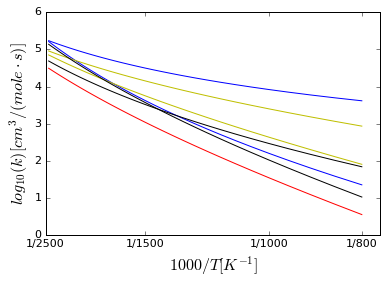

C=CCCCC(C)C


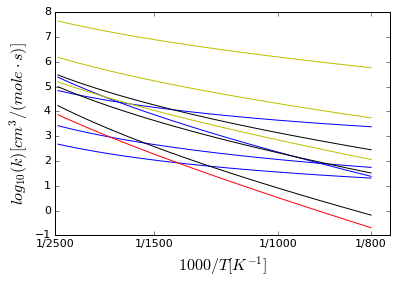

CC(=O)C(C)CC(C)C


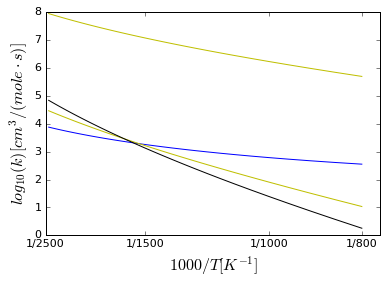

CC(=O)OCCC(C)C


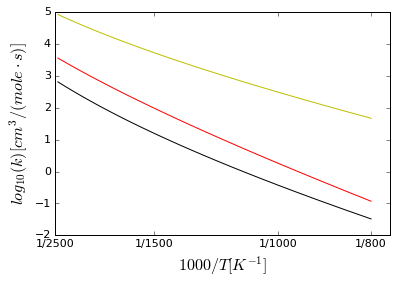

CC(C)(C)OCC(CO)OC(C)(C)C


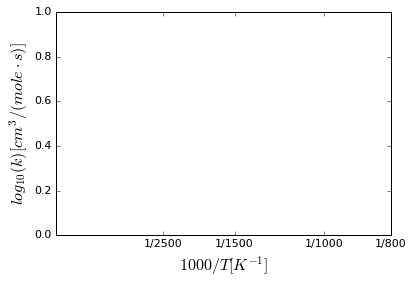

CC(C)CC(=O)CC(C)C


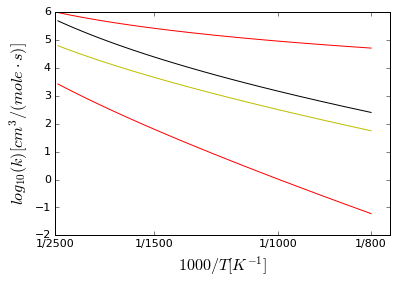

CC(C)CC(C)(C)C


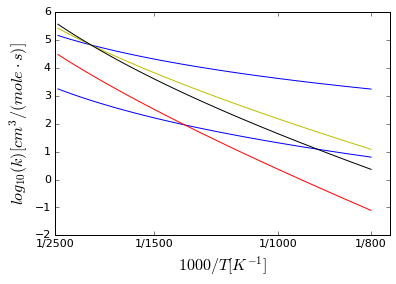

CC1=CCC2CC1C2(C)C


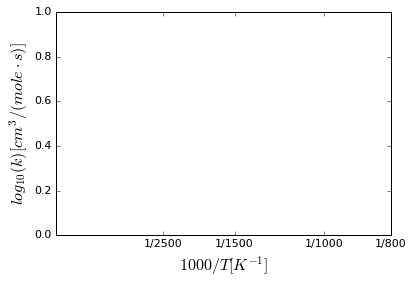

CC1=CCCC1=O


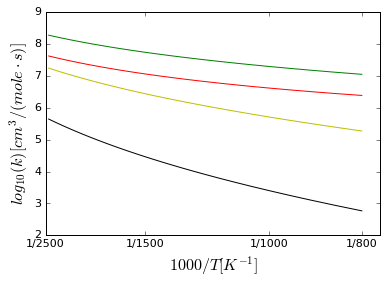

CC1C=CC(C)=CC=1


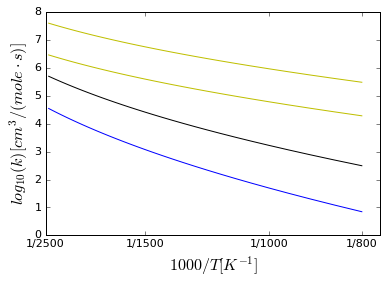

CC1CCCC1


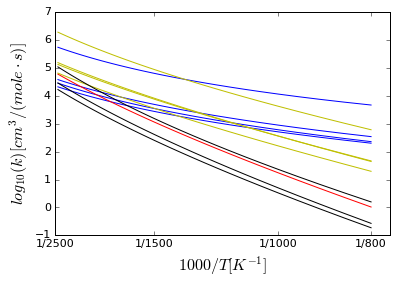

CC=CCCC(C)C


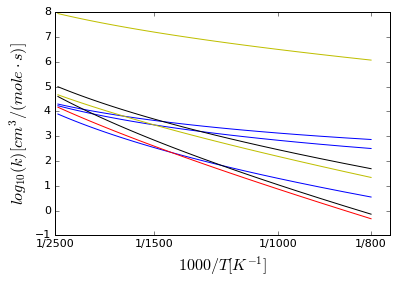

CCC(C)(C)O


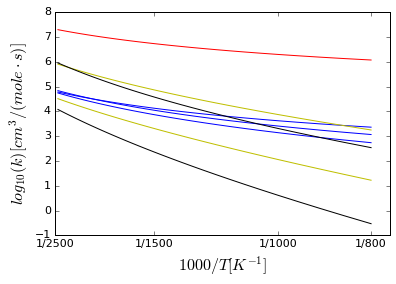

CCC(C)CC(C)C


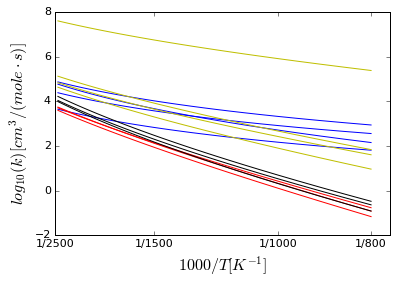

CCC(CC)OC(C)C


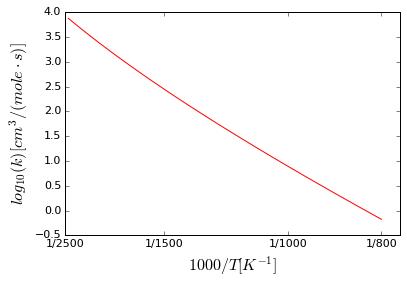

CCC=CCC(C)C


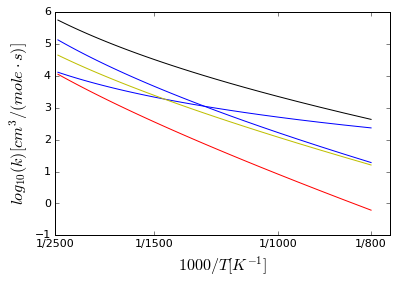

CCCC(C)C=C(C)C


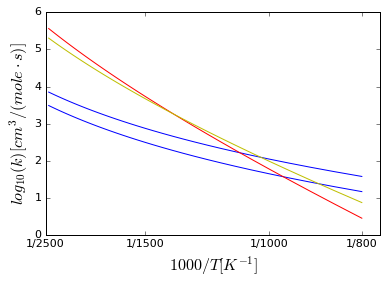

CCCC(C)CO


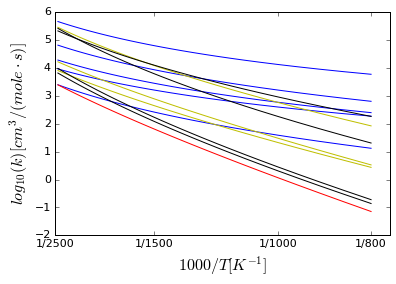

CCCC=CC(C)C


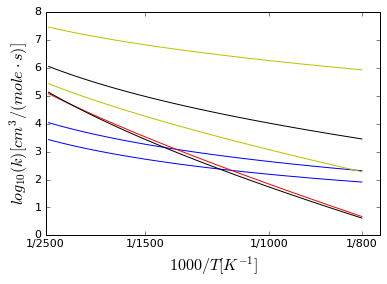

CCCCC(C)CC


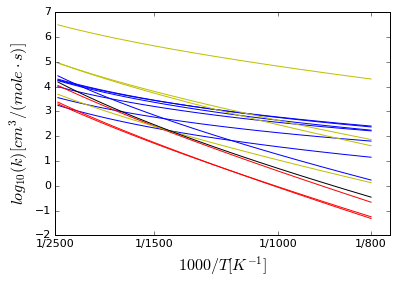

CCCCC=C(C)C


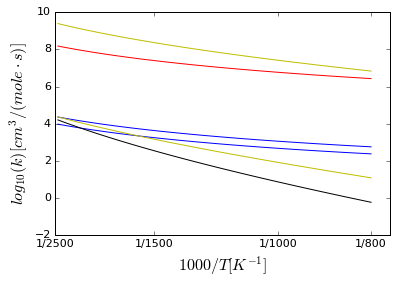

CCCCCC1CCC(C)O1


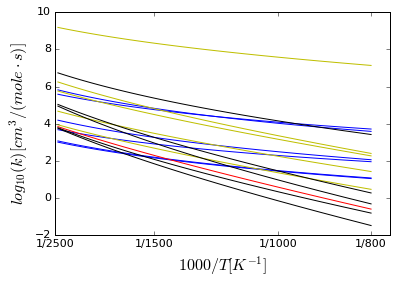

CCOC(=O)C(C)C


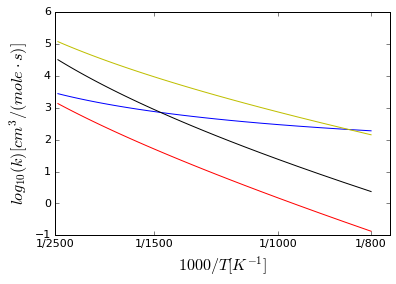

In [7]:

color_list = ["g", "k", "b", "y", 'r', 'w']
color_dict = dict(zip(list_of_abstractors, color_list))
    
T_list = np.arange(800, 2500, 50)
    
def applyArrhenius(x):
    T_list = np.arange(800, 2500,50)
    k_list = []
    try:
        for Temp in T_list:
            k_list.append(Arrhenius.getRateCoefficient(x, Temp, P=1e5))
        k_list = np.array(k_list)
    except TypeError:
        k_list = None
        print "Type error, passing this one"
        
    return np.array(k_list)
    
df["List of rate coefficients"] = df["Arrhenius Expression"].apply(applyArrhenius)


for parent in list_of_parents:
    reactions_of_interest = df[df["Parent Molecule"] == parent]
    fig, ax = plt.subplots()
    
    for i in range(len(reactions_of_interest[reactions_of_interest["List of rate coefficients"].notnull()]["List of rate coefficients"])):
        list = reactions_of_interest[reactions_of_interest["List of rate coefficients"].notnull()]["List of rate coefficients"].iloc[i]
        abstractor = reactions_of_interest[reactions_of_interest["List of rate coefficients"].notnull()]["Abstractor"].iloc[i]
        c = color_dict[abstractor]
        plt.plot(1000. / T_list, np.log10(list), color = c, label = abstractor)
    print parent
    plt.xlabel("$1000/T [K^{-1}]$", fontsize=16)
    plt.ylabel("$log_{10}(k) [cm^3 / (mole \cdot s)]$", fontsize=16)

    Tticks = [800, 1000, 1500, 2500]
    ax.set_xticks([1000./T for T in Tticks])
    ax.set_xticklabels(['1/{:.0f}'.format(T) for T in Tticks])
    plt.tick_params(axis='x', labelsize=11)
    plt.tick_params(axis='y', labelsize=11)
    
    #plt.legend(fontsize=10)
    #lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=9)
    plt.show()
    fig.savefig("/gss_gpfs_scratch/harms.n/plots" + parent +'.pdf', bbox_inches='tight')
  

# Creates plots for the two factor Arrhenius prefactor vs the two factor activation energy

[O]
[CH3]
[O]O
[H]
[OH]
[O][O]
Boo


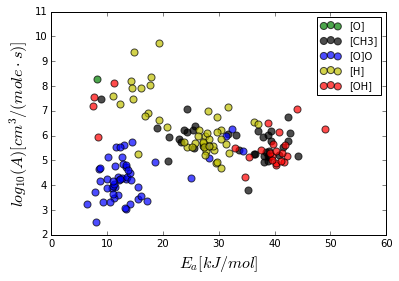

In [8]:
fig, ax = plt.subplots()
for abstractor in list_of_abstractors:
    try:
        print abstractor
        c = color_dict[abstractor]
        df[((df["Arrhenius Expression"] > 1) & (df["Abstractor"] == abstractor))][["Fitted $E_a$", "Fitted $ln(A)$"]].plot(
            x="Fitted $E_a$", 
            y="Fitted $ln(A)$", 
            kind="scatter", 
            alpha= 0.7,
            color=c,
            edgecolor="k",
            ax=ax,
            legend=True,
            s=50
            
        )
        
    except:
        print "Boo"
        
    
plt.legend(tuple(list_of_abstractors), fontsize=10)
plt.xlabel("$E_a [kJ / mol]$", fontsize=16)
plt.ylabel("$log_{10}(A) [cm^3 / (mole \cdot s)]$", fontsize=16)
fig.savefig("/gss_gpfs_scratch/harms.n/plots" + "combined.pdf", bbox_inches='tight')

In [9]:
a

array(['C', 'C=CC(C)=CCCC(=C)C', 'C=CCCCC(C)C', 'CC(=O)C(C)CC(C)C',
       'CC(=O)OCCC(C)C', 'CC(C)(C)OCC(CO)OC(C)(C)C', 'CC(C)CC(=O)CC(C)C',
       'CC(C)CC(C)(C)C', 'CC1=CCC2CC1C2(C)C', 'CC1=CCCC1=O',
       'CC1C=CC(C)=CC=1', 'CC1CCCC1', 'CC=CCCC(C)C', 'CCC(C)(C)O',
       'CCC(C)CC(C)C', 'CCC(CC)OC(C)C', 'CCC=CCC(C)C', 'CCCC(C)C=C(C)C',
       'CCCC(C)CO', 'CCCC=CC(C)C', 'CCCCC(C)CC', 'CCCCC=C(C)C',
       'CCCCCC1CCC(C)O1', 'CCOC(=O)C(C)C', 'O', 'OO', '[CH3]', '[O]',
       '[O]O', '[O][O]'], dtype=object)

# fig, ax = plt.subplots()

for abstractor in list_of_abstractors:
    a, b = df[((df["Has Kinetics"] == 1) & (df["Abstractor"] == abstractor))][["Fitted $E_a$", "Fitted $ln(A)$"]].mean()
    if np.isfinite(a):
        
        color = color_dict[abstractor]
        c, d = df[((df["Has Kinetics"] == 1) & (df["Abstractor"] == abstractor))][["Fitted $E_a$", "Fitted $ln(A)$"]].std()
        #s = df[((df["Has Kinetics"] == 1) & (df["Abstractor"] == abstractor))][["Fitted $E_a$", "Fitted $ln(A)$"]].shape[0] * 25
        plt.scatter(a,b, c=color, label=abstractor, s=50, alpha = 0.7)
        ax.errorbar(a, b, xerr = c, yerr=d, c=color, elinewidth=2, markeredgewidth=2)

plt.legend( fontsize=10)
plt.xlabel("$E_a [kJ / mol]$", fontsize=16)
plt.xlim([0,60])
plt.ylim([2,11])
plt.ylabel("$log_{10}(A) [cm^3 / (mole \cdot s)]$", fontsize=16)
fig.savefig("average_combined.pdf", bbox_inches='tight')




[O]
[CH3]
[O]O
[H]
[OH]
[O][O]
Boo


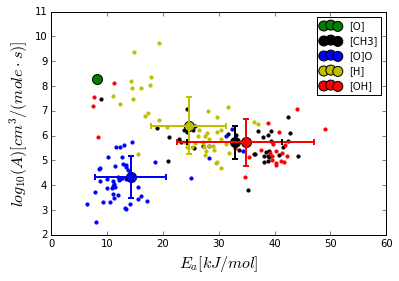

In [10]:
fig, ax = plt.subplots()
for abstractor in list_of_abstractors:
    try:
        print abstractor
        c = color_dict[abstractor]
        df[((df["Arrhenius Expression"] > 1) & (df["Abstractor"] == abstractor))][["Fitted $E_a$", "Fitted $ln(A)$"]].plot(
            x="Fitted $E_a$", 
            y="Fitted $ln(A)$", 
            kind="scatter", 
            alpha= 1,
            color=c,
            edgecolor=c,
            ax=ax,
            legend=True,
            s=10
            
        )
        
    except:
        print "Boo"
        
for abstractor in list_of_abstractors:
    a, b = df[((df["Has Kinetics"] == 1) & (df["Abstractor"] == abstractor))][["Fitted $E_a$", "Fitted $ln(A)$"]].mean()
    if np.isfinite(a):
        
        color = color_dict[abstractor]
        c, d = df[((df["Has Kinetics"] == 1) & (df["Abstractor"] == abstractor))][["Fitted $E_a$", "Fitted $ln(A)$"]].std()
        #s = df[((df["Has Kinetics"] == 1) & (df["Abstractor"] == abstractor))][["Fitted $E_a$", "Fitted $ln(A)$"]].shape[0] * 25
        plt.scatter(a,b, c=color, label=abstractor, s=100)
        ax.errorbar(a, b, xerr = c, yerr=d, c=color, elinewidth=2, markeredgewidth=2)

plt.legend( fontsize=10)
plt.xlabel("$E_a [kJ / mol]$", fontsize=16)
plt.xlim([0,60])
plt.ylim([2,11])
plt.ylabel("$log_{10}(A) [cm^3 / (mole \cdot s)]$", fontsize=16)
fig.savefig("average_combined.pdf", bbox_inches='tight')
#plt.legend(tuple(list_of_abstractors), fontsize=10)
#plt.xlabel("$E_a [kJ / mol]$", fontsize=16)
#plt.ylabel("$log_{10}(A) [cm^3 / (mole \cdot s)]$", fontsize=16)
fig.savefig("/gss_gpfs_scratch/harms.n/plots" + "average_and_combined.pdf", bbox_inches='tight')

[O]


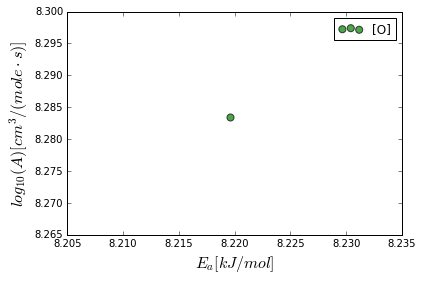

[CH3]


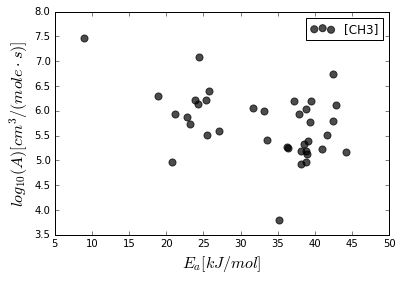

[O]O


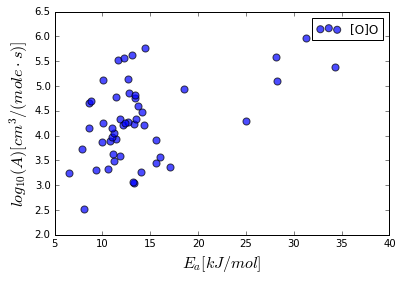

[H]


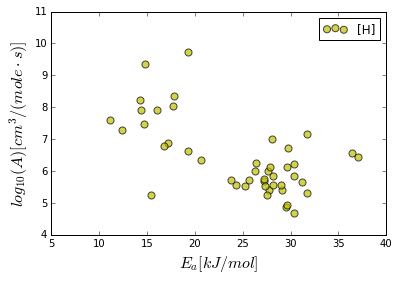

[OH]


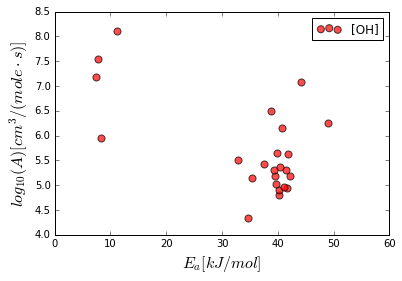

[O][O]
Boo


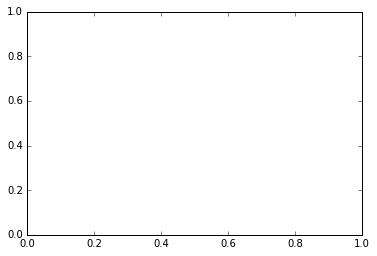

In [11]:

for abstractor in list_of_abstractors:
    try:
        print abstractor
        fig, ax = plt.subplots()
        c = color_dict[abstractor]
        df[((df["Arrhenius Expression"] > 1) & (df["Abstractor"] == abstractor))][["Fitted $E_a$", "Fitted $ln(A)$"]].plot(
            x="Fitted $E_a$", 
            y="Fitted $ln(A)$", 
            kind="scatter", 
            alpha= 0.7,
            color=c,
            edgecolor="k",
            legend=True,
            s=50,
            label=abstractor,
            ax=ax
            
        )
        #plt.legend( fontsize=10)
        plt.xlabel("$E_a [kJ / mol]$", fontsize=16)
        plt.ylabel("$log_{10}(A) [cm^3 / (mole \cdot s)]$", fontsize=16)
        plt.show()
        #fig.savefig(abstractor + "_combined.pdf", bbox_inches='tight')
        
    except:
        print "Boo"


In [12]:

for parent in list_of_parents:
    print parent
    fig, ax = plt.subplots()
    for abstractor in list_of_abstractors:
        try:
            #print abstractor
            c = color_dict[abstractor]
            df[((df["Arrhenius Expression"] > 1) & (df["Abstractor"] == abstractor) & (df["Parent Molecule"] == parent))][["Fitted $E_a$", "Fitted $ln(A)$"]].plot(
                x="Fitted $E_a$", 
                y="Fitted $ln(A)$", 
                kind="scatter", 
                alpha= 0.7,
                color=c,
                edgecolor="k",
                ax=ax,
                legend=True,
                s=50,
                label=abstractor

            )

        except:
            print "Boo"
    plt.legend( fontsize=10)
    plt.xlabel("$E_a [kJ / mol]$", fontsize=16)
    plt.ylabel("$log_{10}(A) [cm^3 / (mole \cdot s)]$", fontsize=16)
    plt.show()
    #fig.savefig("/gss_gpfs_scratch/harms.n/plots" + parent + "_combined.pdf", bbox_inches='tight')

SyntaxError: invalid syntax (<ipython-input-12-5137e92aab80>, line 29)

In [ ]:
df.sort_values("Fitted $E_a$", ascending=False)

In [ ]:
fig, ax = plt.subplots()
for abstractor in list_of_abstractors:
    x = df[((df["Arrhenius Expression"] > 1) & (df["Abstractor"] == abstractor))][["Fitted $E_a$", "Fitted $ln(A)$"]]
    try:
        print abstractor
        c = color_dict[abstractor]
        df[((df["Arrhenius Expression"] > 1) & (df["Abstractor"] == abstractor))][["Fitted $E_a$", "Fitted $ln(A)$"]].plot(
            x="Fitted $E_a$", 
            y="Fitted $ln(A)$", 
            kind="scatter", 
            alpha= 0.7,
            color=c,
            edgecolor="k",
            ax=ax,
            legend=True,
            s=50
            
        )
        
    except:
        print "Boo"
plt.legend(tuple(list_of_abstractors), fontsize=10)
plt.xlabel("$E_a [kJ / mol]$", fontsize=16)
plt.ylabel("$log_{10}(A) [cm^3 / (mole \cdot s)]$", fontsize=16)
#fig.savefig("combined.pdf", bbox_inches='tight')

## This portion is trying to look at the difference between RMG predictions and AutoTST predictions

In [13]:
from rmgpy.data.rmg import RMGDatabase
print('Loading RMG Database ...')
rmgDatabase = RMGDatabase()
databasePath = os.path.abspath(os.path.join(os.getenv('RMGpy', '..'), '..', 'RMG-database', 'input'))

rmgDatabase.load(databasePath,
                 kineticsFamilies=["H_Abstraction"],
                 transportLibraries=[],
                 reactionLibraries=[],
                 seedMechanisms=[],
                 thermoLibraries=['primaryThermoLibrary', 'KlippensteinH2O2', 'thermo_DFT_CCSDTF12_BAC', 'CBS_QB3_1dHR' ],
                 solvation=False,
                 )
print('RMG Database Loaded')

loadSpecies = rmgDatabase.kinetics.families["H_Abstraction"]
species_dict_file = os.path.expanduser('~/Code/OOHabstraction/bioTST/generateReactionsOutput/chemkin/species_dictionary.txt')
species_dict = loadSpecies.getSpecies(species_dict_file)

chemkin_file = "/home/harms.n/Code/OOHabstraction/bioTST/generateReactionsOutput/chemkin/chem_annotated.inp"

with open(chemkin_file, "r") as f:
    lines = f.readlines()
rxnList = {}
gotit = []
rxnFamily = "H_Abstraction"
for k, line in enumerate(lines):
    if line.startswith('! Template reaction: '):
        for m in range(10):
            reaction = lines[k+m]
            if reaction.startswith('!'):
                continue
            else:
                rxn, A, n, E_a = reaction.split()
                reactants, products = rxn.split('=')
                
                rSpecies1, rSpecies2 = [species_dict[j] for j in reactants.split('+')]
                pSpecies1, pSpecies2 = [species_dict[j] for j in products.split('+')]
                
                rSpecies1.generateResonanceIsomers()
                rSpecies2.generateResonanceIsomers()
                pSpecies1.generateResonanceIsomers()
                pSpecies2.generateResonanceIsomers()
    
                rxn = Reaction(reactants=[rSpecies1, rSpecies2], products=[pSpecies1, pSpecies2], reversible=True)
                
                
                rxnList[rxn] = [A, n, E_a]
                break
dff = pd.DataFrame(rxnList).T
dff.columns =["$A$", "$n$", "$E_a$"]
dff


Loading RMG Database ...
RMG Database Loaded


,$A$,$n$,$E_a$
O(4) + O2(6) <=> OOH(1) + OH(2),1.351e+04,2.559,2.741
OOH(1) + OOH(1) <=> O2(6) + O2(30),3.500e+10,0.000,-3.275
OOH(1) + C8H18(9) <=> O2(6) + C8H17(46),2.800e+12,0.000,16.013
O2(6) + C8H17(47) <=> OOH(1) + C8H18(9),1.660e-07,5.407,0.040
O2(6) + C8H17(48) <=> OOH(1) + C8H18(9),1.660e-07,5.407,0.040
O2(6) + C8H17(49) <=> OOH(1) + C8H18(9),1.660e-07,5.407,0.040
O2(6) + C8H17(50) <=> OOH(1) + C8H18(9),1.660e-07,5.407,0.040
O2(6) + C8H17(51) <=> OOH(1) + C8H18(9),3.000e+00,3.280,1.050
O2(6) + C8H17(52) <=> OOH(1) + C8H18(9),3.000e+00,3.280,1.050
O2(6) + C8H17(53) <=> OOH(1) + C8H18(9),3.000e+00,3.280,1.050


In [ ]:
#lambda rxn a: Reaction.isIsomerization(a, index, eitherDirection=True)

for index in df["Reaction"]:
    for rxn in dff.index.values:
        if Reaction.isIsomorphic(index, rxn) == True:
            print rxn
            break


## This porition is designed to compare the abstraction on simimar molecule between two abstractors

In [ ]:
df[df["Has Kinetics"] == 1]

In [ ]:

OH_Ea_list = []
OOH_Ea_list = []


for abstractor in list_of_abstractors:
    if abstractor == "[OH]":
        continue
    OH_Ea_list = []
    OOH_Ea_list = []
    color = color_dict[abstractor]
    for parent in list_of_parents:
        
        #print parent
        abstraction_df = df[(df.index == parent) & (df["Has Kinetics"] == 1)].sort("Radical Molecule")
        try:
            OH_Ea = abstraction_df[abstraction_df["Abstractor"] == "[OH]"]["Fitted $E_a$"]
            OOH_Ea = abstraction_df[abstraction_df["Abstractor"] == abstractor]["Fitted $E_a$"]
            print OH_Ea, OOH_Ea

        except:
            print "No OH or OOH kinetics"
        OH_Ea_list.append(OH_Ea)
        OOH_Ea_list.append(OOH_Ea)

    plt.scatter(OH_Ea_list, OOH_Ea_list, c=color)
plt.show()

# Creating the table of all the info needed for each abstraction. w/ two factor information and rates at 1000 K, 1e5 Pa

# $\ln(k) = -\frac{E_a}{R} \cdot \frac{1}{T} + \ln(A)$

# $k = A \cdot T^n \cdot \exp(-\frac{E_a}{R\cdot T})$

# $k = A \cdot \exp(-\frac{E_a}{R\cdot T})$

In [ ]:
Molecule(SMILES="CC1CCCC1")